In [1]:
import numpy as np
import seaborn as sns


# Heatmap Example

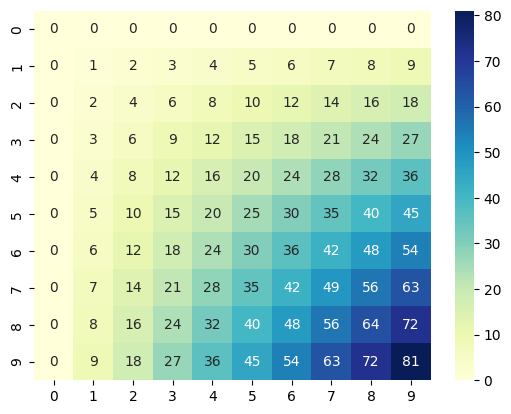

In [2]:
def generate_heatmap_data():
    # Generate a 10x10 matrix of random numbers
    data = [[i * j for j in range(10)] for i in range(10)]
    return data

def plot_heatmap(data):
    # Create a heatmap using seaborn
    sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu")

# Generate the data
data = generate_heatmap_data()

# Plot the heatmap
heatmap = plot_heatmap(data)


In [3]:
def state_to_coords(state_num):
    """
    Convert a state number to (x, y) coordinates in a 6x12 grid.

    Parameters:
    state_num (int): The state number (0-71)
    has_wall (bool): Whether there's a wall at column 7

    Returns:
    tuple: (row, col) coordinates
    """
    if state_num < 0 or state_num > 71:
        raise ValueError("State number must be between 0 and 71")

    row = state_num // 12
    col = state_num % 12

    if col in [
        6,  7,  8,  9, 10, 11,
        18, 19, 20, 21, 22, 23,
        30, 31, 32, 33, 34, 35,
        42, 43, 44, 45, 46, 47,
        54, 55, 56, 57, 58, 59,
        66, 67,  68, 69, 70, 71
        ]:
        col += 1

    return row, col


def plot_heatmap_from_state_scores(env, state_scores):
    """
    Plot a heatmap of state scores (different metrics) for a given environment.
    """

    size = env.size
    rows, cols = size
    cols += 1
    data = np.zeros((rows, cols))
    data[:, env.room_size] = -1.  # left room
    data[env.hallway_height, env.room_size] = 0.  # hallway

    for state, score in state_scores.items():
        row, col = state_to_coords(state)
        data[row, col] = score

    # sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu")
    sns.heatmap(data)


state_to_coords(55)

(4, 8)

# Sample Trajectories

In [4]:
from agent import SMDPQLearning
from env import TwoRooms, get_primitive_actions_as_options
from trajectory_sampler import sample


In [5]:
default_s0 = 24
left_room = [
    0, 1, 2, 3, 4, 5,
    12, 13, 14, 15, 16, 17,
    24, 25, 26, 27, 28, 29,
    36, 37, 38, 39, 40, 41,
    48, 49, 50, 51, 52, 53,
    60, 61, 62, 63, 64, 65,
]

In [6]:
# Create the environment
env = TwoRooms(
    start_state=default_s0,
    goal_state=68,
    negative_states_config="none",
    max_steps=None
)

# Set up the agent with primitive options (actions)
primitive_options = get_primitive_actions_as_options(env)

agent = SMDPQLearning(
    env,
    primitive_options,
    learning_rate=0.1,
    discount_factor=0.99,
    exploration_rate=0.1,
    min_exploration_rate=0.1,
    exploration_decay=1
)

# Sample trajectories
print("Sampling trajectories...")
n_samples = 50
trajectories, results, steps = sample(env, agent, n_samples)


Sampling trajectories...


100%|██████████| 50/50 [00:01<00:00, 39.50it/s]


# Heatmaps

## Every visit X First visit

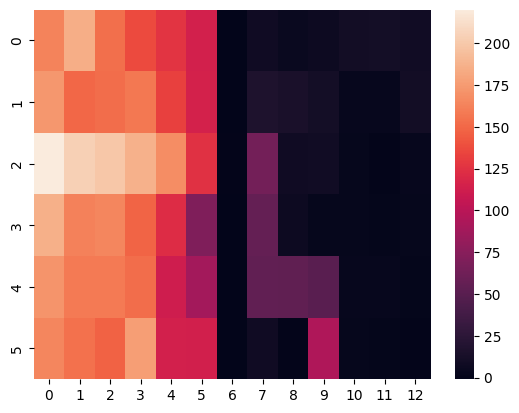

In [7]:
every_visit_scores = {s: 0.0 for s in range(env.observation_space.n)}
for t in trajectories:
    for s in t:
        if s == env.goal_transition_state:
            continue
        every_visit_scores[s] += 1.0

plot_heatmap_from_state_scores(env, every_visit_scores)


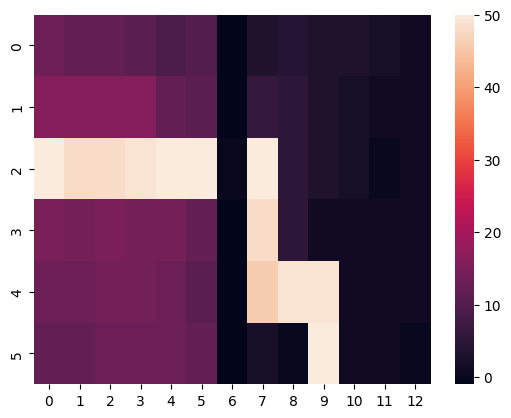

In [8]:
first_visit_scores = {s: 0.0 for s in range(env.observation_space.n)}
for t in trajectories:
    visited = set()
    for s in t:
        if s == env.goal_transition_state or s in visited:
            continue
        first_visit_scores[s] += 1.0
        visited.add(s)

plot_heatmap_from_state_scores(env, first_visit_scores)


## Diverse Density

In [9]:
from subgoal_discovery import diverse_density

In [10]:
dd_tuples = diverse_density(trajectories, results, threshold=0.0)
dd_scores = {s: 0.0 for s in range(env.observation_space.n)}
for s, dd in dd_tuples:
    if s == env.goal_transition_state:
        continue
    dd_scores[s] = dd
dd_scores[0]


0.0

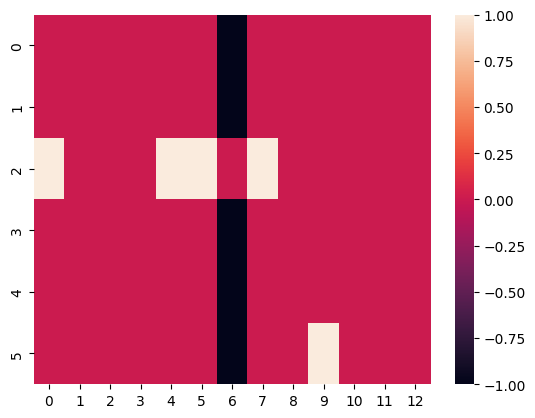

In [11]:
plot_heatmap_from_state_scores(env, dd_scores)

## Relative Novelty

In [12]:
from subgoal_discovery import relative_novelty


In [13]:
subgoals = relative_novelty(trajectories, novelty_lag=7)
subgoals


[np.int64(29), np.int64(68)]

In [22]:
rn_scores = relative_novelty(trajectories, novelty_lag=7, return_scores=True)
rn_scores_filtered = {s: 1.0 if score_threshold[0] > score_threshold[1] else 0.0 for s, score_threshold in rn_scores.items()}
rn_scores_filtered


{np.int64(63): 0.0,
 np.int64(62): 0.0,
 np.int64(61): 0.0,
 np.int64(64): 0.0,
 np.int64(65): 0.0,
 np.int64(53): 0.0,
 np.int64(41): 0.0,
 np.int64(40): 0.0,
 np.int64(28): 0.0,
 np.int64(29): 1.0,
 np.int64(17): 0.0,
 np.int64(16): 0.0,
 np.int64(4): 0.0,
 np.int64(3): 0.0,
 np.int64(5): 0.0,
 np.int64(52): 0.0,
 np.int64(50): 0.0,
 np.int64(51): 0.0,
 np.int64(39): 0.0,
 np.int64(27): 0.0,
 np.int64(15): 0.0,
 np.int64(2): 0.0,
 np.int64(26): 0.0,
 np.int64(25): 0.0,
 np.int64(37): 0.0,
 np.int64(36): 0.0,
 np.int64(24): 0.0,
 np.int64(38): 0.0,
 np.int64(68): 1.0,
 np.int64(30): 0.0,
 np.int64(18): 0.0,
 np.int64(19): 0.0,
 np.int64(20): 0.0,
 np.int64(32): 0.0,
 np.int64(33): 0.0,
 np.int64(31): 0.0,
 np.int64(7): 0.0,
 np.int64(8): 0.0,
 np.int64(9): 0.0,
 np.int64(10): 0.0,
 np.int64(21): 0.0,
 np.int64(6): 0.0,
 np.int64(42): 0.0,
 np.int64(54): 0.0,
 np.int64(55): 0.0,
 np.int64(43): 0.0,
 np.int64(60): 0.0,
 np.int64(48): 0.0,
 np.int64(12): 0.0,
 np.int64(13): 0.0,
 np.int6

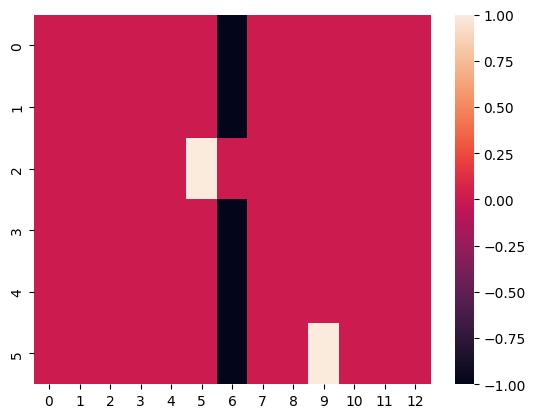

In [23]:
plot_heatmap_from_state_scores(env, rn_scores_filtered)
